In [1]:
import sys
sys.path.append('../../code/')

In [12]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from libs import helpers
from libs.metrics import aggregators
from libs.metrics import helpers as helpers_metrics
from postprocessing import factuality
from postprocessing import bias

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [13]:
APS_OA_DATA_TAR_GZ = '../../../APS/data/final_dataset.tar.gz'
APS_OS_DISCIPLINE_DEMOGRAPHICS = '../../results/interventions/metadata/disciplines_author_demographics.csv'

DATA_PATH = '../../results/temperature-analysis'
SUMMARY_PATH = io.path_join(DATA_PATH, 'summaries')
VALID_RESPONSES_PATH = io.path_join(DATA_PATH, 'valid_responses')
FACTUALITY_RESPONSES_PATH = io.path_join(DATA_PATH, 'factuality')

RESULTS_PATH = '../../results/interventions'
PLOTS_PATH = io.path_join(RESULTS_PATH, 'plots')    
TABLES_PATH = io.path_join(RESULTS_PATH, 'tables')
LATEX_PATH = io.path_join(RESULTS_PATH, 'latex')

io.validate_path(PLOTS_PATH)
io.validate_path(TABLES_PATH)
io.validate_path(LATEX_PATH)


# Data

In [14]:
# Load the summary data for each model (all outputs)
df_summary = io.pd.concat([io.read_csv(io.path_join(SUMMARY_PATH, f"experiments_{model}.csv"), low_memory=False) for model in constants.LLMS], ignore_index=True)
df_valid_responses = io.pd.concat([io.read_csv(io.path_join(VALID_RESPONSES_PATH, f"{model}.csv"), index_col=0, low_memory=False) for model in constants.LLMS], ignore_index=True)
df_factuality_author = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_RESPONSES_PATH, f"{model}_author.csv"), index_col=0, low_memory=False) for model in constants.LLMS], ignore_index=True)

df_summary.shape, df_valid_responses.shape, df_factuality_author.shape
# ((26789, 20), (521942, 17), (521942, 36))


((26789, 20), (521942, 17), (521942, 36))

In [15]:
# demographics
df_all_authors_demographics = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_AUTHORS_DEMOGRAPHICS_FN)
df_all_authors_demographics.rename(columns={'id_author':'id_author_oa'}, inplace=True)

# scholarly stats
df_all_authors_stats = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_AUTHORS_STATS_FN)
df_all_authors_stats.rename(columns={'id_author':'id_author_oa'}, inplace=True)

# per discipline
df_gt_stats = io.read_csv(APS_OS_DISCIPLINE_DEMOGRAPHICS, index_col=0, header=[0, 1])

# gt (from APS)
df_gt = df_all_authors_demographics[['id_author_oa','first_name','last_name','ethnicity','gender']].copy()
df_gt = df_gt.merge(df_all_authors_stats[['id_author_oa','works_count','cited_by_count', 'rr1_rank_publications','rr1_rank_publications_percentile', 'rr2_rank_citations','rr2_rank_citations_percentile']], on='id_author_oa', how='left')
df_gt = helpers.add_quantiles(df_gt)

# shapes
df_all_authors_demographics.shape, df_gt_stats.shape, df_gt_stats.shape, df_gt.shape

((481012, 14), (17, 19), (17, 19), (481012, 13))

## Augmenting data

In [37]:
# adding prominence metrics to recommended authors
df_factuality_author = df_factuality_author.merge(df_gt[['id_author_oa', 'prominence_pub', 'prominence_cit']], on='id_author_oa', how='left')

# adding infrastructure metadata
df_summary = helpers.add_infrastructure_columns(df_summary)
df_factuality_author = helpers.add_infrastructure_columns(df_factuality_author)

# shapes
df_summary.shape, df_factuality_author.shape


((26789, 25), (521942, 45))

# Plots

In [38]:
vis.sns_reset()
vis.sns_paper_style(font_scale=1.55)

In [ ]:
FIGSIZE = (10, 2.5)
FIGSIZE_TOP = (10, 2.7)
PLOT_KWARGS = {'figsize':FIGSIZE, 'ylim':(0, 1), 'show_xticks':True, 'show_xlabel':True}
# PLOT_KWARGS_D = {'figsize':FIGSIZE, 'ylim':(0, 0.06), 'show_xticks':True}
# PLOT_KWARGS_M = {'figsize':FIGSIZE, 'ylim':(0, 0.5), 'show_xticks':True}
# PLOT_KWARGS_H = {'figsize':FIGSIZE, 'ylim':(0, 0.2), 'show_xticks':True}
PLOT_KWARGS_TOP = {'figsize':FIGSIZE_TOP, 'ylim':(0, 1), 'show_title':True, 
                  'show_xticks':True, 'show_xlabel':True, 'show_legend':True, 'legend_kwargs':{'loc':'best'}}

In [39]:
per_attempt_validity = helpers_metrics.load_per_attempt('factuality_author', df_factuality_author, TABLES_PATH, prefix='temperature')
per_attempt_diversity_gender = helpers_metrics.load_per_attempt('diversity_gender', df_factuality_author, TABLES_PATH, prefix='temperature')
per_attempt_parity_gender = helpers_metrics.load_per_attempt('parity_gender', df_factuality_author, TABLES_PATH, gt=df_gt, prefix='temperature')


In [100]:
METRICS = ['validity_pct',
           'factuality_author', 
           'diversity_gender', 
           'parity_gender']

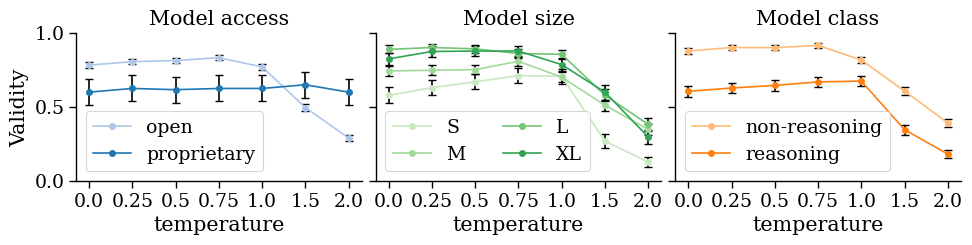

In [101]:
metric = 'validity_pct'
xvar = 'temperature'
fn = helpers_metrics.get_plot_fn(metric, PLOTS_PATH, prefix=xvar)
per_attempt = helpers_metrics.load_per_attempt(metric, None, TABLES_PATH, prefix=xvar)
per_attempt = helpers.add_infrastructure_columns(per_attempt)
vis.plot_infrastructural_conditions_by_intervention(per_attempt, fn=fn, xvar=xvar, ylabel=metric, **PLOT_KWARGS_TOP)


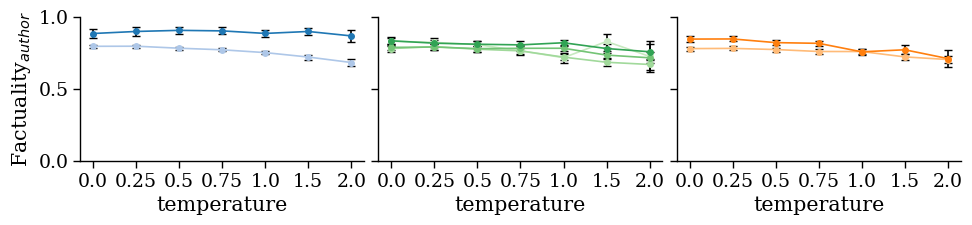

In [102]:
metric = 'factuality_author'
xvar = 'temperature'
fn = helpers_metrics.get_plot_fn(metric, PLOTS_PATH, prefix=xvar)
per_attempt = helpers_metrics.load_per_attempt(metric, None, TABLES_PATH, prefix=xvar)
per_attempt = helpers.add_infrastructure_columns(per_attempt)
vis.plot_infrastructural_conditions_by_intervention(per_attempt, fn=fn, xvar=xvar, ylabel=metric, **PLOT_KWARGS)


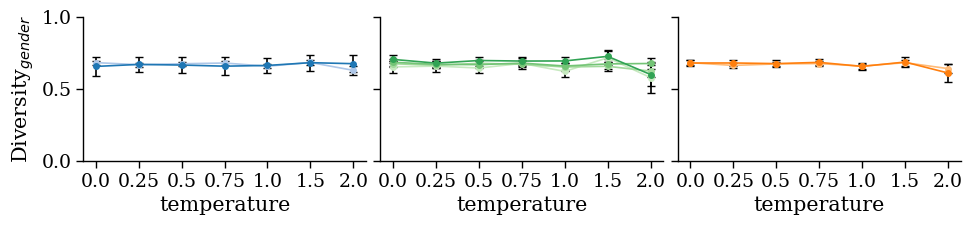

In [103]:
metric = 'diversity_gender'
xvar = 'temperature'
fn = helpers_metrics.get_plot_fn(metric, PLOTS_PATH, prefix=xvar)
per_attempt = helpers_metrics.load_per_attempt(metric, None, TABLES_PATH, prefix=xvar)
per_attempt = helpers.add_infrastructure_columns(per_attempt)
vis.plot_infrastructural_conditions_by_intervention(per_attempt, fn=fn, xvar=xvar, ylabel=metric, **PLOT_KWARGS)


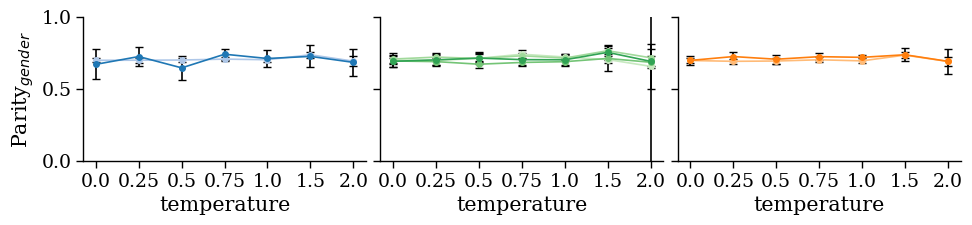

In [104]:
metric = 'parity_gender'
xvar = 'temperature'
fn = helpers_metrics.get_plot_fn(metric, PLOTS_PATH, prefix=xvar)
per_attempt = helpers_metrics.load_per_attempt(metric, None, TABLES_PATH, prefix=xvar)
per_attempt = helpers.add_infrastructure_columns(per_attempt)
vis.plot_infrastructural_conditions_by_intervention(per_attempt, fn=fn, xvar=xvar, ylabel=metric, **PLOT_KWARGS)


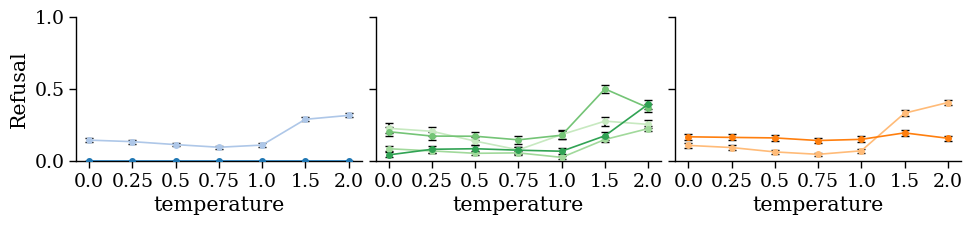

In [97]:
metric = 'refusal_pct'
xvar = 'temperature'
fn = helpers_metrics.get_plot_fn(metric, PLOTS_PATH, prefix=xvar)
per_attempt = helpers_metrics.load_per_attempt(metric, None, TABLES_PATH, prefix=xvar)
per_attempt = helpers.add_infrastructure_columns(per_attempt)
vis.plot_infrastructural_conditions_by_intervention(per_attempt, fn=fn, xvar=xvar, ylabel=metric, **PLOT_KWARGS)


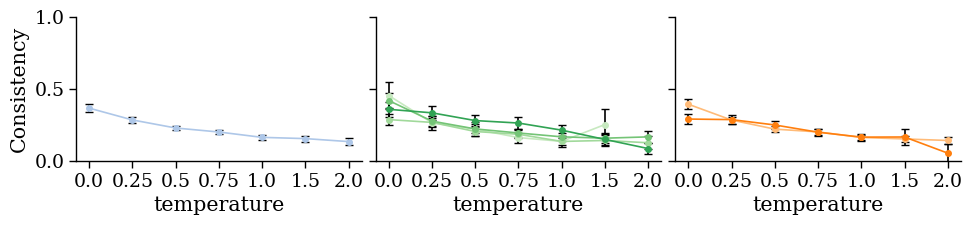

In [98]:
metric = 'consistency'
xvar = 'temperature'
fn = helpers_metrics.get_plot_fn(metric, PLOTS_PATH, prefix=xvar)
per_attempt = helpers_metrics.load_per_attempt(metric, None, TABLES_PATH, prefix=xvar)
per_attempt = helpers.add_infrastructure_columns(per_attempt)
vis.plot_infrastructural_conditions_by_intervention(per_attempt, fn=fn, xvar=xvar, ylabel=metric, **PLOT_KWARGS)


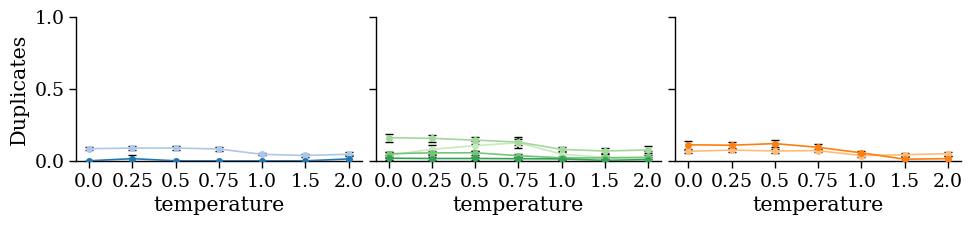

In [99]:
metric = 'duplicates'
xvar = 'temperature'
fn = helpers_metrics.get_plot_fn(metric, PLOTS_PATH, prefix=xvar)
per_attempt = helpers_metrics.load_per_attempt(metric, None, TABLES_PATH, prefix=xvar)
per_attempt = helpers.add_infrastructure_columns(per_attempt)
vis.plot_infrastructural_conditions_by_intervention(per_attempt, fn=fn, xvar=xvar, ylabel=metric, **PLOT_KWARGS)
